# Predicting movie success using Machine Learning algorithms


****Here’s what we’ve done in this notebook:****
- **Explore the Data**: We’ll dive into the `movie_metadata.csv` dataset, look at its features, and visualize patterns to understand what makes a movie successful.
- **Clean the Data**: We’ll handle missing values, cap outliers, and make the data ready for modeling.
- **Engineer Features**: We’ll create new features and even experiment with combining some to see what works best.
- **Build Models**: We’ll train three models (RandomForest, GradientBoosting and XGBoost) to predict movie success and compare their performance.
- **Add a Fun Twist**: At the end, we’ll generate marketing taglines for movies using a pretrained LLM (DeepSeek-v3 API accessed Via [openrouter.ai](https://openrouter.ai))

# Table of Contents

- [Library Imports](#library-imports)
- [Set Visualization Style](#set-visualization-style)
- [Load the Dataset](#load-the-dataset)
- [Basic EDA](#basic-eda)
- [Extended EDA with Visualizations](#extended-eda)
- [Data Cleaning](#data-cleaning)
- [Feature Engineering](#feature-engineering)
- [Preprocessing, Training, and Evaluation](#preprocessing-training-evaluation)
- [Model Training and Comparison](#model-training-comparison)
- [Marketing Tagline Generation](#tagline-generation)

---

*Click on any section to jump directly to it!*

# Import Libraries <a id="library-imports"></a>

In [10]:
# Let’s gather all the tools we’ll need for our project! 🛠️
import pandas as pd  # For data manipulation and reading CSV files
import numpy as np  # For numerical computations and array operations
import matplotlib.pyplot as plt  # For creating basic visualizations like histograms and scatter plots
import seaborn as sns  # For enhanced statistical visualizations like heatmaps and bar plots
import warnings  # To suppress non-critical warnings for cleaner output
from sklearn.model_selection import train_test_split, GridSearchCV  # For splitting data and hyperparameter tuning
from sklearn.preprocessing import LabelEncoder, StandardScaler, MultiLabelBinarizer  # For encoding categorical variables and scaling numerical features
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # For RandomForest and GradientBoosting classification models
from sklearn.metrics import classification_report, confusion_matrix  # For evaluating model performance with metrics
from collections import Counter  # For counting genres in EDA to analyze distributions
from xgboost import XGBClassifier  # For XGBoost classification model, a powerful gradient boosting algorithm
from transformers import pipeline  # For loading pretrained LLMs to generate marketing taglines

## Set Visualization Style and supress warnings <a id="set-visualization-style"></a>

In [11]:
#Lets supress the warnings and set a visualization style to maintain a same consistency for whole document
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')  # Clean, gridlined style for Matplotlib plots
sns.set_palette('deep')  # Vibrant, distinct colors for Seaborn plots

# Load the Dataset <a id="load-the-dataset"></a>

In [12]:
# I’m using a try-except here because I don’t want the script to crash if the file isn’t found.
try:
    df = pd.read_csv('movie_metadata.csv')
    print("Dataset loaded successfully! Let’s take a peek.")
except FileNotFoundError:
    print("Error: 'movie_metadata.csv' not found in the current directory.")
    raise

Dataset loaded successfully! Let’s take a peek.


# Basic EDA <a id="basic-eda"></a>

In [13]:
# Let’s explore the dataset to understand what we’re working with. 🕵️‍♂️
# We want to check how many movies we have, what features are available, and if there are any missing values.
print(f"Dataset has {df.shape[0]} rows and {df.shape[1]} columns")
print("\n=== Dataset Info ===")
print(df.info())  # Display column names, data types, and non-null counts
print("\n=== Missing Values ===")
print(df.isnull().sum())  # Show missing values per column

# Let’s check the distribution of IMDb scores to understand our target variable
# This will help us see if there’s any imbalance before we categorize it
print("\n=== IMDb Score Distribution ===")
print(df['imdb_score'].describe())

Dataset has 5043 rows and 28 columns

=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_for_reviews     4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_voted_users            5043 non-null   in

# Extended EDA with Visualizations <a id="extended-eda"></a>

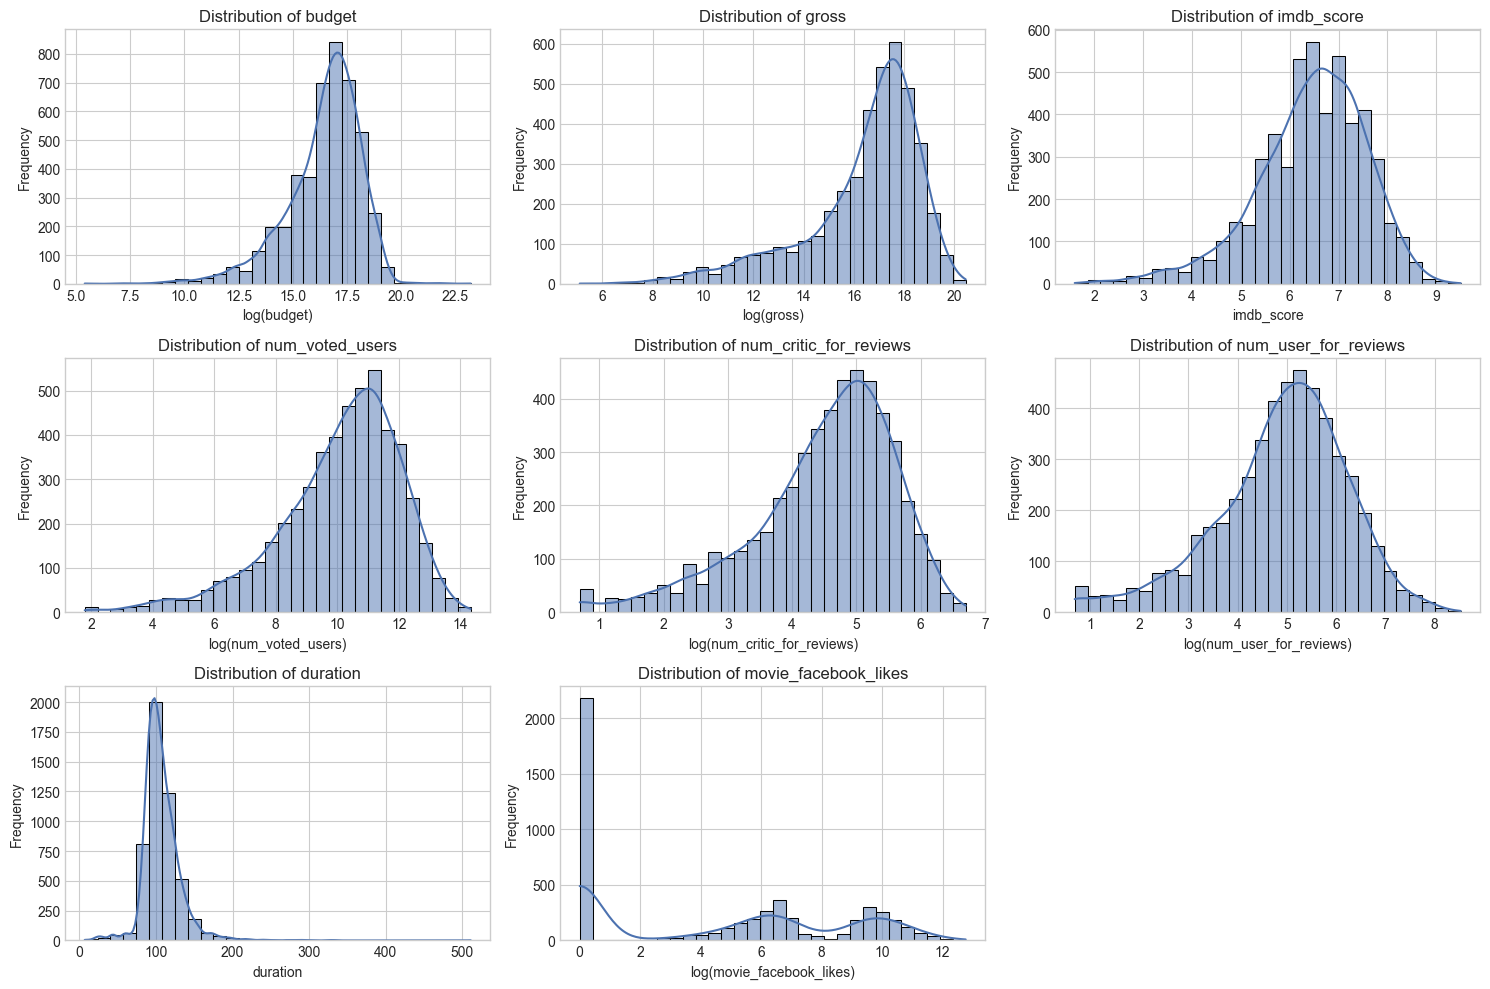

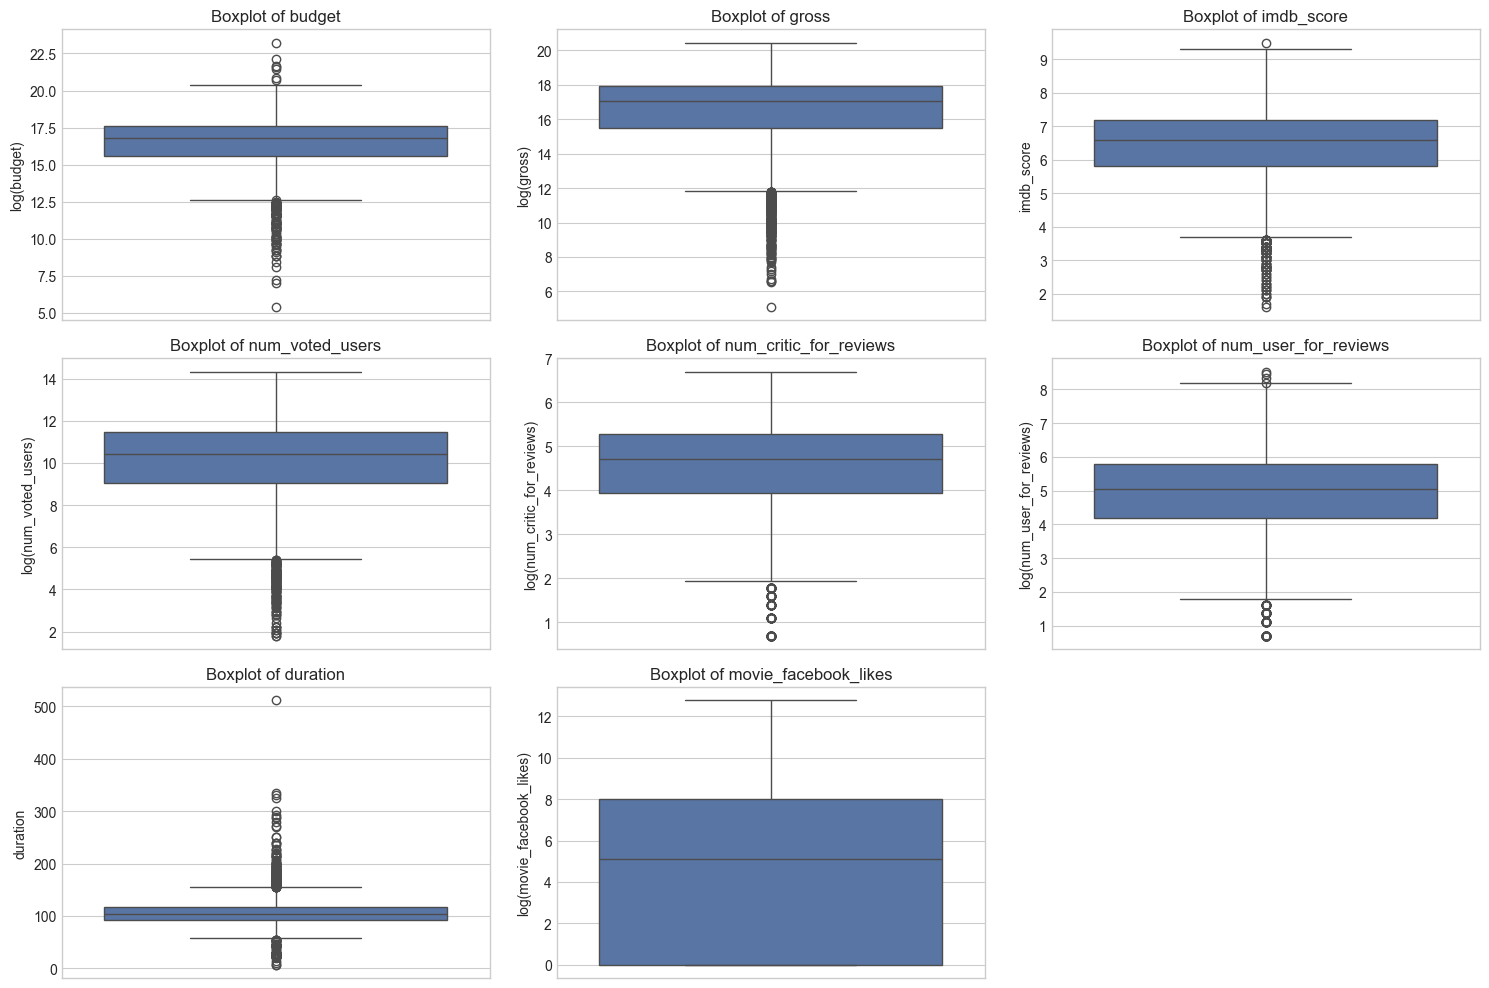

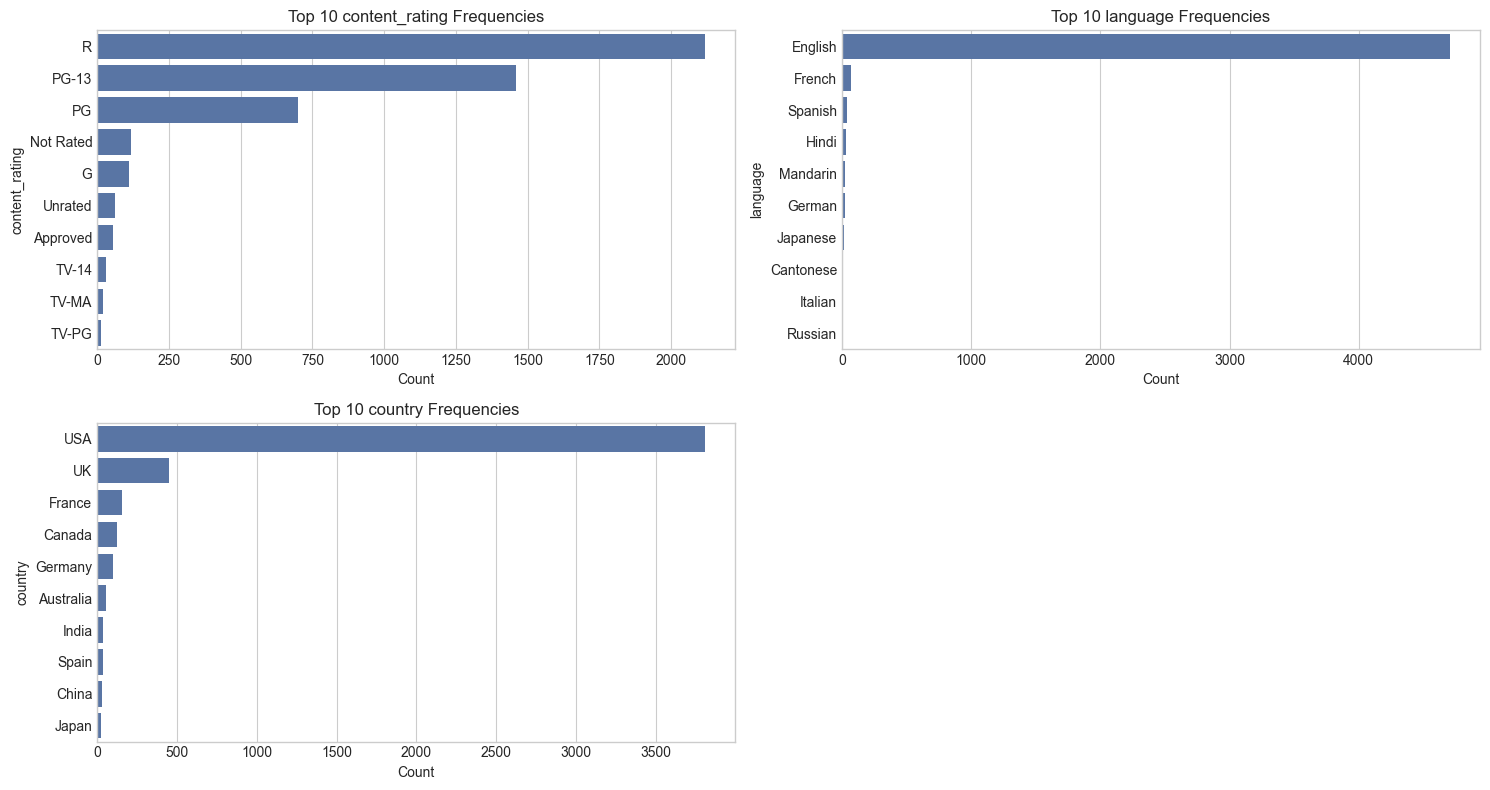

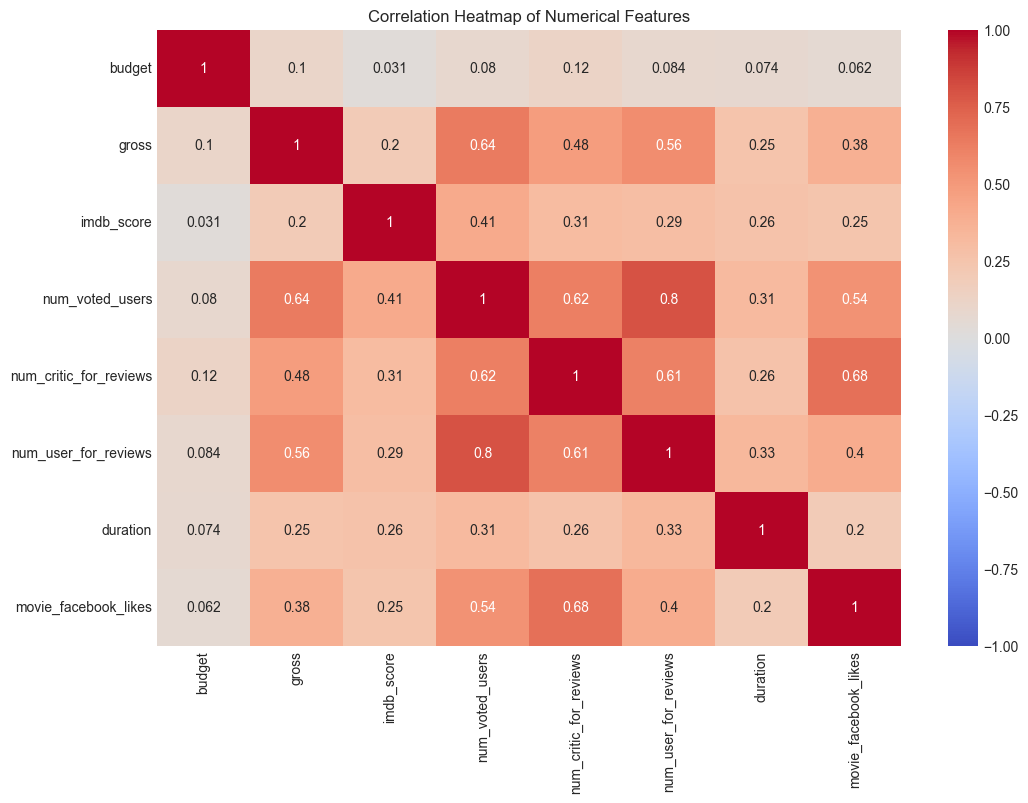

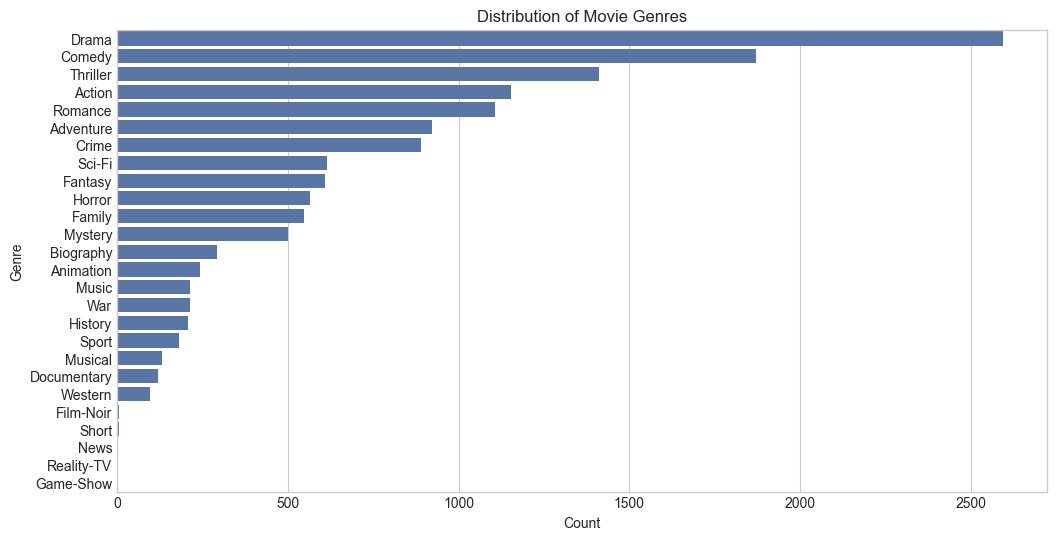

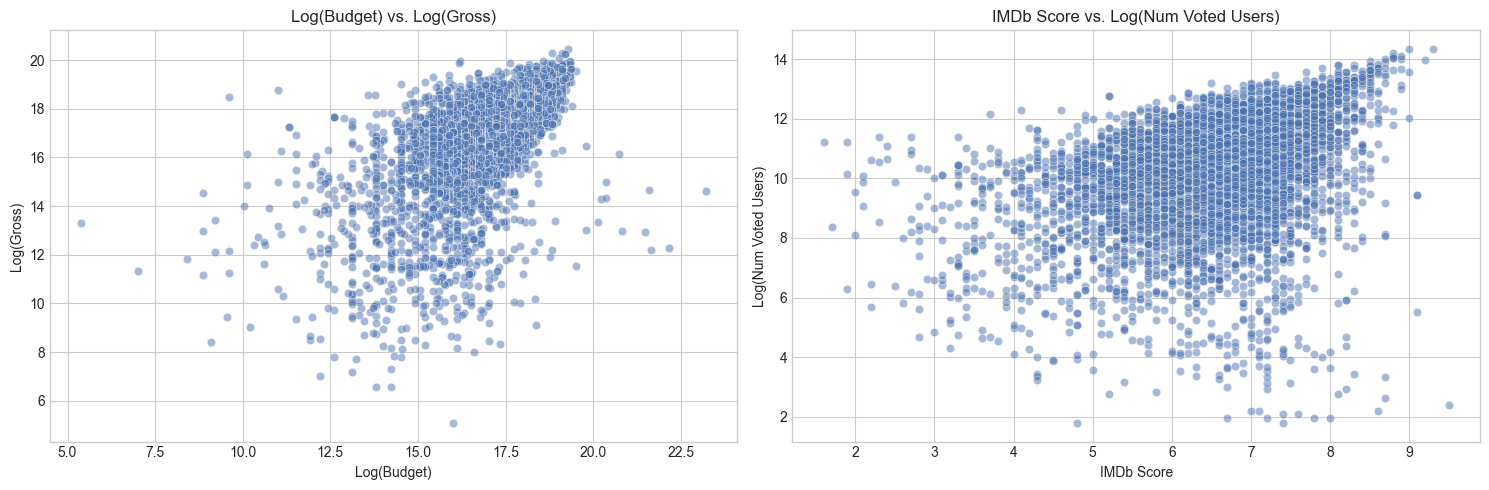

In [14]:
#Now let's visualize the features and compare their correlations and impacts on the target variable.....

# Define numerical and categorical columns for visualization
numerical_cols = ['budget', 'gross', 'imdb_score', 'num_voted_users', 
                  'num_critic_for_reviews', 'num_user_for_reviews', 
                  'duration', 'movie_facebook_likes']
categorical_cols = ['content_rating', 'language', 'country']

# 1. Histogram of Numerical Features (to understand distributions)
plt.figure(figsize=(15, 10))
n_cols = 3  # Number of columns in subplot grid
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols  # Calculate rows dynamically
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    try:
        # Apply log transformation for skewed features to better visualize distributions
        if col in ['budget', 'gross', 'num_voted_users', 'num_critic_for_reviews', 
                   'num_user_for_reviews', 'movie_facebook_likes']:
            sns.histplot(np.log1p(df[col].dropna()), bins=30, kde=True)
            plt.xlabel(f'log({col})')
        else:
            sns.histplot(df[col].dropna(), bins=30, kde=True)
            plt.xlabel(col)
        plt.title(f'Distribution of {col}')
        plt.ylabel('Frequency')
    except Exception as e:
        print(f"Error plotting histogram for {col}: {e}")
plt.tight_layout()
plt.show()

# 2. Boxplot of Numerical Features (to identify outliers)
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    try:
        if col in ['budget', 'gross', 'num_voted_users', 'num_critic_for_reviews', 
                   'num_user_for_reviews', 'movie_facebook_likes']:
            sns.boxplot(y=np.log1p(df[col].dropna()))
            plt.ylabel(f'log({col})')
        else:
            sns.boxplot(y=df[col].dropna())
            plt.ylabel(col)
        plt.title(f'Boxplot of {col}')
    except Exception as e:
        print(f"Error plotting boxplot for {col}: {e}")
plt.tight_layout()
plt.show()

# 3. Bar Plot of Categorical Features (to see category frequencies)
plt.figure(figsize=(15, 8))
n_cols = 2
n_rows = (len(categorical_cols) + n_cols - 1) // n_cols
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    try:
        top_categories = df[col].value_counts().head(10)  # Show top 10 categories for readability
        sns.barplot(x=top_categories.values, y=top_categories.index)
        plt.title(f'Top 10 {col} Frequencies')
        plt.xlabel('Count')
        plt.ylabel(col)
    except Exception as e:
        print(f"Error plotting bar plot for {col}: {e}")
plt.tight_layout()
plt.show()

# 4. Correlation Heatmap (to understand relationships between numerical features)
plt.figure(figsize=(12, 8))
try:
    correlation_matrix = df[numerical_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation Heatmap of Numerical Features')
except Exception as e:
    print(f"Error plotting correlation heatmap: {e}")
plt.show()

# 5. Genre Distribution (to see frequency of each genre)
plt.figure(figsize=(12, 6))
try:
    all_genres = df['genres'].dropna().str.split('|').explode()  # Split genres and explode into individual rows
    genre_counts = Counter(all_genres)
    genre_df = pd.DataFrame.from_dict(genre_counts, orient='index').reset_index()
    genre_df.columns = ['Genre', 'Count']
    genre_df = genre_df.sort_values(by='Count', ascending=False)
    sns.barplot(x='Count', y='Genre', data=genre_df)
    plt.title('Distribution of Movie Genres')
    plt.xlabel('Count')
    plt.ylabel('Genre')
except Exception as e:
    print(f"Error plotting genre distribution: {e}")
plt.show()

# 6. Scatter Plots for Key Relationships (to explore relationships)
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
try:
    sns.scatterplot(x=np.log1p(df['budget']), y=np.log1p(df['gross']), alpha=0.5)
    plt.title('Log(Budget) vs. Log(Gross)')
    plt.xlabel('Log(Budget)')
    plt.ylabel('Log(Gross)')
except Exception as e:
    print(f"Error plotting Budget vs. Gross: {e}")

plt.subplot(1, 2, 2)
try:
    sns.scatterplot(x=df['imdb_score'], y=np.log1p(df['num_voted_users']), alpha=0.5)
    plt.title('IMDb Score vs. Log(Num Voted Users)')
    plt.xlabel('IMDb Score')
    plt.ylabel('Log(Num Voted Users)')
except Exception as e:
    print(f"Error plotting IMDb Score vs. Num Voted Users: {e}")
plt.tight_layout()
plt.show()

# Data Cleaning <a id="data-cleaning"></a>

In [15]:
# We’ll remove duplicates, handle missing values, and cap outliers to ensure our models gets good data.

# 1. Handle Duplicates
# Remove duplicate rows and reset the index to maintain consecutive numbering
df = df.drop_duplicates().reset_index(drop=True)
print(f"After removing duplicates, dataset has {df.shape[0]} rows")

# 2. Handle Missing Values
# Define numerical columns and include title_year
numerical_cols = ['budget', 'gross', 'num_voted_users', 'num_critic_for_reviews', 
                  'num_user_for_reviews', 'duration', 'movie_facebook_likes', 'title_year']

# Ensure title_year is numerical to avoid issues during imputation
df['title_year'] = pd.to_numeric(df['title_year'], errors='coerce')

# Impute missing values in numerical columns with their median (robust to outliers)
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

# Verify missing values after imputation for numerical columns
print("\n=== Missing Values After Imputation (Numerical Columns) ===")
print(df[numerical_cols].isnull().sum())

# Define categorical columns and impute missing values with the mode (most frequent value)
categorical_cols = ['content_rating', 'language', 'country', 'genres']
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Handle missing values in plot_keywords (we’ll need it for tagline generation)
df['plot_keywords'] = df['plot_keywords'].fillna('unknown')  # Replace NaN with 'unknown'

# Verify missing values after imputation for categorical columns and plot_keywords
print("\n=== Missing Values After Imputation (Categorical Columns and plot_keywords) ===")
print(df[categorical_cols + ['plot_keywords']].isnull().sum())

# 3. Cap Outliers (log-transformed)
# Log-transform skewed numerical columns and cap at the 99th percentile to reduce outlier impact
skewed_cols = ['budget', 'gross', 'num_voted_users', 'num_critic_for_reviews', 
               'num_user_for_reviews', 'movie_facebook_likes']
for col in skewed_cols:
    df[col] = np.log1p(df[col])  # Log-transform to reduce skewness
    cap_value = np.percentile(df[col], 99)  # Cap at 99th percentile of log values
    df[col] = df[col].clip(upper=cap_value)

# Cap duration between 60 and 180 minutes (reasonable range for movies)
df['duration'] = df['duration'].clip(lower=60, upper=180)

# Print DataFrame info to confirm cleaning steps
print("\n=== After Data Cleaning ===")
print(df.info())

After removing duplicates, dataset has 4998 rows

=== Missing Values After Imputation (Numerical Columns) ===
budget                    0
gross                     0
num_voted_users           0
num_critic_for_reviews    0
num_user_for_reviews      0
duration                  0
movie_facebook_likes      0
title_year                0
dtype: int64

=== Missing Values After Imputation (Categorical Columns and plot_keywords) ===
content_rating    0
language          0
country           0
genres            0
plot_keywords     0
dtype: int64

=== After Data Cleaning ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      4979 non-null   object 
 1   director_name              4895 non-null   object 
 2   num_critic_for_reviews     4998 non-null   float64
 3   duration                   4998 non-nu

### Reflections on Data Cleaning

While cleaning the dataset, I encountered a few decisions that I’d like to reflect on:

- **Handling `plot_keywords`**: I replaced missing values with 'unknown' to ensure the column is usable for tagline generation. However, I didn’t address potential typos or invalid terms due to the project’s scope. In a real-world scenario, I’d use NLP techniques like spell-checking or keyword normalization to improve data quality.
  
- **Identifying Skewed Columns**: I selected columns like `budget` and `gross` for log-transformation based on their histograms in the [Extended EDA](#extended-eda) section, which showed right-skewed distributions. I could have quantified this using `df[col].skew()` to confirm, but the visual inspection was sufficient for this project.

- **Converting `title_year` to Numeric**: I converted `title_year` to numeric for imputation and modeling purposes. I considered converting it to datetime, but since we’re only using the year and not doing time-series analysis, keeping it as a numerical feature was more straightforward.

# Feature Engineering <a id="feature-engineering"></a>


=== Correlations with imdb_score ===
num_critic_for_reviews: 0.288
num_user_for_reviews: 0.304
num_voted_users: 0.349

=== Weights for engagement_score ===
num_critic_for_reviews: 0.306
num_user_for_reviews: 0.323
num_voted_users: 0.371

=== Class Distribution ===
Classify
Average    2569
Hit        1577
Flop        852
Name: count, dtype: int64


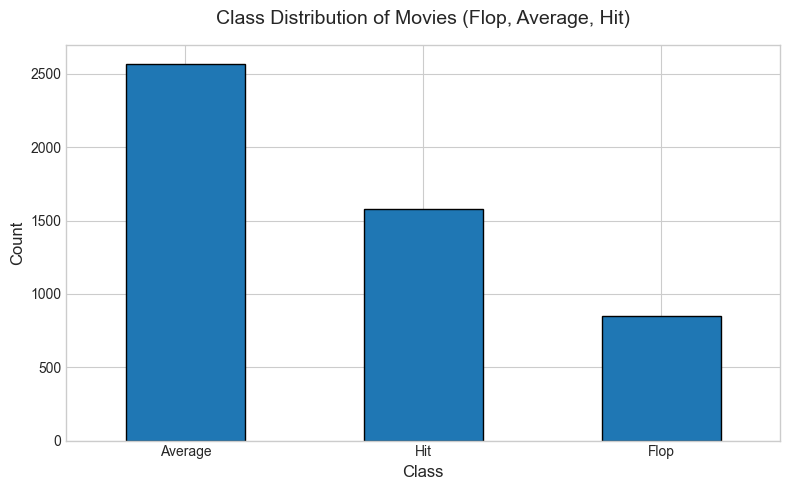


=== After Feature Engineering ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   num_critic_for_reviews  4998 non-null   float64
 1   duration                4998 non-null   float64
 2   gross                   4998 non-null   float64
 3   genres                  4998 non-null   object 
 4   num_voted_users         4998 non-null   float64
 5   plot_keywords           4998 non-null   object 
 6   num_user_for_reviews    4998 non-null   float64
 7   language                4998 non-null   object 
 8   country                 4998 non-null   object 
 9   content_rating          4998 non-null   object 
 10  budget                  4998 non-null   float64
 11  title_year              4998 non-null   float64
 12  movie_facebook_likes    4998 non-null   float64
 13  Classify                4998 non-null   object 
 14  budge

In [16]:
# Let’s create some new features to help our models predict movie success! 🛠️
# I’ll categorize IMDb scores into Flop, Average, and Hit, create new features, and prepare two DataFrames.

# Step 1: Calculate correlations with imdb_score to determine weights for engagement_score in df2
# We use imdb_score (numerical) to calculate correlations since Classify will be categorical
engagement_cols = ['num_critic_for_reviews', 'num_user_for_reviews', 'num_voted_users']
correlations = {}
for col in engagement_cols:
    try:
        corr = df[col].corr(df['imdb_score'])  # Calculate Pearson correlation with imdb_score
        correlations[col] = corr
    except Exception as e:
        print(f"Error calculating correlation for {col}: {e}")
        correlations[col] = 0.0  # Fallback to 0 if correlation fails

# Display correlations for transparency
print("\n=== Correlations with imdb_score ===")
for col, corr in correlations.items():
    print(f"{col}: {corr:.3f}")

# Step 2: Calculate weights for engagement_score
# Use absolute correlations to ensure all weights are positive
# Normalize so weights sum to 1: weight = |correlation| / sum(|correlations|)
abs_correlations = {col: abs(corr) for col, corr in correlations.items()}
total_abs_corr = sum(abs_correlations.values())
if total_abs_corr == 0:
    total_abs_corr = 1.0  # Avoid division by zero
weights = {col: abs_corr / total_abs_corr for col, abs_corr in abs_correlations.items()}

# Display weights for transparency
print("\n=== Weights for engagement_score ===")
for col, weight in weights.items():
    print(f"{col}: {weight:.3f}")

# Step 3: Categorize Target Variable
# Convert imdb_score into categorical Classify (Flop: <5.5, Average: 5.5-7, Hit: >7)
def categorize_imdb_score(score):
    try:
        if not isinstance(score, (int, float)):
            return 'Unknown'
        if score < 5.5:
            return 'Flop'
        elif 5.5 <= score <= 7:
            return 'Average'
        elif score > 7:
            return 'Hit'
        else:
            return 'Unknown'  # Handle any unexpected values
    except Exception as e:
        print(f"Error categorizing IMDb score {score}: {e}")
        return 'Unknown'

df['Classify'] = df['imdb_score'].apply(categorize_imdb_score)
# Check for 'Unknown' categories and handle them (impute with mode)
if 'Unknown' in df['Classify'].values:
    print("\nWarning: Some IMDb scores resulted in 'Unknown' category. Imputing with mode...")
    mode_class = df[df['Classify'] != 'Unknown']['Classify'].mode()[0]
    df['Classify'] = df['Classify'].replace('Unknown', mode_class)

df = df.drop('imdb_score', axis=1)  # Drop imdb_score as we now use Classify

# Quick check of class distribution to understand the balance
print("\n=== Class Distribution ===")
class_dist = df['Classify'].value_counts()
print(class_dist)

# Visualize class distribution for presentation
plt.figure(figsize=(8, 5))
class_dist.plot(kind='bar', color='#1f77b4', edgecolor='black')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Class Distribution of Movies (Flop, Average, Hit)', fontsize=14, pad=15)
plt.xticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# Step 4: Drop Irrelevant Columns
# Remove columns that are unlikely to contribute to prediction or are redundant
# Keep plot_keywords for tagline generation
irrelevant_cols = ['movie_title', 'director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name', 
                   'movie_imdb_link', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
                   'actor_3_facebook_likes', 'cast_total_facebook_likes', 'director_facebook_likes',
                   'aspect_ratio', 'facenumber_in_poster', 'color']
# Check if columns exist before dropping to avoid errors
existing_irrelevant_cols = [col for col in irrelevant_cols if col in df.columns]
df = df.drop(columns=existing_irrelevant_cols)

# Step 5: Create New Features
# Budget to Gross Ratio: Measures financial efficiency (log-transformed budget / gross)
df['budget_to_gross_ratio'] = df['budget'] / df['gross']
df['budget_to_gross_ratio'] = df['budget_to_gross_ratio'].replace([np.inf, -np.inf], np.nan)
df['budget_to_gross_ratio'] = df['budget_to_gross_ratio'].fillna(df['budget_to_gross_ratio'].median())

# Genre Count: Number of genres per movie (indicates diversity of appeal)
df['genre_count'] = df['genres'].str.split('|').apply(len)

# Print DataFrame info to confirm feature engineering
print("\n=== After Feature Engineering ===")
print(df.info())

# Step 6: Create Two DataFrames for Comparison
# df1: Keep all features as is
# df2: Combine num_critic_for_reviews, num_user_for_reviews, num_voted_users into engagement_score
df1 = df.copy()
df2 = df.copy()

# Create engagement_score for df2 using weighted average
df2['engagement_score'] = (
    weights['num_critic_for_reviews'] * df2['num_critic_for_reviews'] +
    weights['num_user_for_reviews'] * df2['num_user_for_reviews'] +
    weights['num_voted_users'] * df2['num_voted_users']
)

# Drop the original engagement columns from df2
engagement_cols_to_drop = ['num_critic_for_reviews', 'num_user_for_reviews', 'num_voted_users']
df2 = df2.drop(columns=engagement_cols_to_drop)

# Print info for both DataFrames to confirm
print("\n=== df1 Info ===")
print(df1.info())
print("\n=== df2 Info ===")
print(df2.info())

### Reflections on Feature Engineering

After feature engineering, here are some key observations:

- **Class Imbalance in `Classify`**: The class distribution shows a significant imbalance: 1577 movies are classified as `Hit`, 2569 as `Average`, and only 852 as `Flop`. This imbalance could bias our models toward predicting `Average` more often, so I’ll use `class_weight='balanced'` as a hyperparameter to assign inverse weights to compensate minority class.

- **Correlations and Weights for `engagement_score`**: The correlations with `imdb_score` (`num_voted_users`: 0.349, `num_user_for_reviews`: 0.304, `num_critic_for_reviews`: 0.288) show that `num_voted_users` has the strongest relationship with movie success, which makes sense—popular movies tend to get more votes. The weights (`num_voted_users`: 0.371, `num_user_for_reviews`: 0.323, `num_critic_for_reviews`: 0.306) reflect this, giving more importance to `num_voted_users` in the `engagement_score` for `df2`.

- **New Features**: I created `budget_to_gross_ratio` to capture financial efficiency and `genre_count` to measure the diversity of a movie’s appeal. These features should help the models identify patterns in movie success. Keeping `plot_keywords` ensures we can generate taglines later.

This step sets us up nicely for preprocessing and model training!

# Preprocessing, Training, and Evaluation <a id="preprocessing-training-evaluation"></a>

In [17]:
# Let’s build a function to preprocess the data, train our models, and evaluate them! 🧠
# We’ll optimize the process with a subset for tuning and 4 CPU cores for parallelism.
# We’ll also return the preprocessed DataFrame and encoders for reuse in tagline generation.

def preprocess_train_and_evaluate(DF):
    """
    Preprocesses the DataFrame, trains RandomForest, GradientBoosting, and XGBoost classifiers,
    and evaluates their performance with optimized settings for faster execution.

    Parameters:
    DF (pandas.DataFrame): Input DataFrame with features and target (Classify).

    Returns:
    dict: Evaluation metrics for all models.
    RandomForestClassifier: The best trained RandomForest model.
    list: Feature names after preprocessing.
    pandas.DataFrame: Preprocessed DataFrame with original columns (genres, plot_keywords).
    dict: Encoders and scalers used for preprocessing (for reuse).
    """
    # Create a copy to avoid modifying the original DataFrame
    df = DF.copy()
    
    # Step 1: Encode Categorical Features
    # Group all non-standard content_rating values into 'Other'
    valid_ratings = ['G', 'PG', 'PG-13', 'R']
    df['content_rating'] = df['content_rating'].apply(lambda x: x if x in valid_ratings else 'Other')
    df['language'] = df['language'].apply(lambda x: 'English' if x == 'English' else 'Other')
    df['country'] = df['country'].apply(lambda x: 'USA' if x == 'USA' else 'Other')

    # Hybrid encoding: LabelEncoder for content_rating, one-hot for language and country
    le = LabelEncoder()
    le.fit(['G', 'PG', 'PG-13', 'R', 'Other'])  # Define categories to match training
    df['content_rating'] = le.transform(df['content_rating'])
    df = pd.get_dummies(df, columns=['language', 'country'], prefix=['lang', 'country'], drop_first=True)

    # Encode genres using MultiLabelBinarizer (since genres are multi-label)
    mlb = MultiLabelBinarizer()
    mlb.fit(df['genres'].str.split('|'))  # Fit on all genres in the dataset
    genres_encoded = pd.DataFrame(
        mlb.transform(df['genres'].str.split('|')),
        columns=mlb.classes_,
        index=df.index
    )
    # Keep the original genres column for tagline generation
    df = pd.concat([df, genres_encoded], axis=1)

    # Step 2: Feature Scaling
    # Define numerical columns manually based on whether we're processing df1 or df2
    if 'engagement_score' in df.columns:  # df2
        numerical_cols_df = ['duration', 'gross', 'budget', 'movie_facebook_likes', 
                             'title_year', 'budget_to_gross_ratio', 'genre_count', 'engagement_score']
    else:  # df1
        numerical_cols_df = ['num_critic_for_reviews', 'duration', 'gross', 'budget', 'num_voted_users', 
                             'num_user_for_reviews', 'movie_facebook_likes', 
                             'title_year', 'budget_to_gross_ratio', 'genre_count']
    
    # Double-check that all numerical columns exist in the DataFrame
    missing_cols = [col for col in numerical_cols_df if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing numerical columns for scaling: {missing_cols}")

    # Scale numerical columns using StandardScaler (mean=0, std=1)
    scaler = StandardScaler()
    df[numerical_cols_df] = scaler.fit_transform(df[numerical_cols_df])

    # Step 3: Prepare Data for Modeling
    # Split features (X) and target (y), with 70-30 train-test split, stratified on y
    X = df.drop(['Classify', 'plot_keywords', 'genres'], axis=1)  # Exclude plot_keywords and genres from modeling
    y = df['Classify']
    feature_names = X.columns.tolist()  # Store feature names for plotting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Print class distribution in the training and test sets
    print("\n=== Class Distribution (Training Set) ===")
    print(pd.Series(y_train).value_counts())
    print("\n=== Class Distribution (Test Set) ===")
    print(pd.Series(y_test).value_counts())

    # Subset the training data for hyperparameter tuning to speed up GridSearchCV
    subset_ratio = 0.5  # Use 50% of training data for tuning
    X_train_subset, _, y_train_subset, _ = train_test_split(
        X_train, y_train, train_size=subset_ratio, random_state=42, stratify=y_train
    )
    print(f"\n=== Subset for Hyperparameter Tuning ({subset_ratio*100}% of Training Data) ===")
    print(pd.Series(y_train_subset).value_counts())

    # Step 4: Train Models with GridSearchCV
    # Use 4 CPU cores for parallelism to balance speed and system load
    n_jobs = 4

    # Model 1: RandomForestClassifier
    rf_param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2']
    }
    rf = RandomForestClassifier(random_state=42, class_weight='balanced')
    rf_grid = GridSearchCV(rf, rf_param_grid, cv=5, scoring='f1_macro', n_jobs=n_jobs)
    rf_grid.fit(X_train_subset, y_train_subset)
    rf_best = rf_grid.best_estimator_
    # Retrain on full training set with best parameters
    rf_best.fit(X_train, y_train)
    print("\n=== RandomForestClassifier Best Params ===")
    print(rf_grid.best_params_)

    # Model 2: GradientBoostingClassifier
    gb_param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'min_samples_split': [2, 5],
        'subsample': [0.8, 1.0]
    }
    gb = GradientBoostingClassifier(random_state=42)
    gb_grid = GridSearchCV(gb, gb_param_grid, cv=5, scoring='f1_macro', n_jobs=n_jobs)
    gb_grid.fit(X_train_subset, y_train_subset)
    gb_best = gb_grid.best_estimator_
    # Retrain on full training set with best parameters
    gb_best.fit(X_train, y_train)
    print("\n=== GradientBoostingClassifier Best Params ===")
    print(gb_grid.best_params_)

    # Model 3: XGBoostClassifier
    xgb_param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'min_child_weight': [1, 3],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    # Compute class weights for XGBoost
    from sklearn.utils.class_weight import compute_class_weight
    classes = np.unique(y_train)
    weights = compute_class_weight('balanced', classes=classes, y=y_train)
    class_weight_dict = dict(zip(range(len(classes)), weights))
    xgb = XGBClassifier(random_state=42, eval_metric='mlogloss', scale_pos_weight=class_weight_dict)
    xgb_grid = GridSearchCV(xgb, xgb_param_grid, cv=5, scoring='f1_macro', n_jobs=n_jobs)
    
    # Encode target labels for XGBoost (it requires numerical labels)
    le_y = LabelEncoder()
    y_train_subset_encoded = le_y.fit_transform(y_train_subset)
    y_train_encoded = le_y.transform(y_train)
    y_test_encoded = le_y.transform(y_test)
    xgb_grid.fit(X_train_subset, y_train_subset_encoded)
    xgb_best = xgb_grid.best_estimator_
    # Retrain on full training set with best parameters
    xgb_best.fit(X_train, y_train_encoded)
    print("\n=== XGBoostClassifier Best Params ===")
    print(xgb_grid.best_params_)

    # Step 5: Evaluate Models
    # Evaluate RandomForestClassifier on the test set
    rf_pred = rf_best.predict(X_test)
    print("\n=== RandomForestClassifier Evaluation ===")
    rf_report = classification_report(y_test, rf_pred, output_dict=True)
    print(classification_report(y_test, rf_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, rf_pred))

    # Evaluate GradientBoostingClassifier on the test set
    gb_pred = gb_best.predict(X_test)
    print("\n=== GradientBoostingClassifier Evaluation ===")
    gb_report = classification_report(y_test, gb_pred, output_dict=True)
    print(classification_report(y_test, gb_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, gb_pred))

    # Evaluate XGBoostClassifier on the test set
    xgb_pred = xgb_best.predict(X_test)
    xgb_pred_labels = le_y.inverse_transform(xgb_pred)  # Convert back to original labels
    print("\n=== XGBoostClassifier Evaluation ===")
    xgb_report = classification_report(y_test, xgb_pred_labels, output_dict=True)
    print(classification_report(y_test, xgb_pred_labels))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, xgb_pred_labels))

    # Step 6: Prepare preprocessed DataFrame for reuse
    # Keep original columns (genres, plot_keywords, engagement_score) alongside encoded ones
    preprocessed_df = df.copy()

    # Step 7: Store encoders and scalers for reuse
    preprocessing_tools = {
        'label_encoder_content_rating': le,
        'multi_label_binarizer_genres': mlb,
        'scaler': scaler,
        'label_encoder_target': le_y,
        'numerical_cols': numerical_cols_df
    }

    # Return evaluation metrics, the trained RandomForest model, feature names,
    # preprocessed DataFrame, and preprocessing tools
    return {
        'RandomForest': {
            'best_params': rf_grid.best_params_,
            'macro_f1': rf_report['macro avg']['f1-score'],
            'classification_report': rf_report,
            'confusion_matrix': confusion_matrix(y_test, rf_pred),
            'best_estimator': rf_best
        },
        'GradientBoosting': {
            'best_params': gb_grid.best_params_,
            'macro_f1': gb_report['macro avg']['f1-score'],
            'classification_report': gb_report,
            'confusion_matrix': confusion_matrix(y_test, gb_pred),
            'best_estimator': gb_best
        },
        'XGBoost': {
            'best_params': xgb_grid.best_params_,
            'macro_f1': xgb_report['macro avg']['f1-score'],
            'classification_report': xgb_report,
            'confusion_matrix': confusion_matrix(y_test, xgb_pred_labels),
            'best_estimator': xgb_best
        }
    }, rf_best, feature_names, preprocessed_df, preprocessing_tools

# Model Training and Comparison <a id="model-training-comparison"></a>

=== Training and Evaluating on df1 ===

=== Class Distribution (Training Set) ===
Classify
Average    1798
Hit        1104
Flop        596
Name: count, dtype: int64

=== Class Distribution (Test Set) ===
Classify
Average    771
Hit        473
Flop       256
Name: count, dtype: int64

=== Subset for Hyperparameter Tuning (50.0% of Training Data) ===
Classify
Average    899
Hit        552
Flop       298
Name: count, dtype: int64

=== RandomForestClassifier Best Params ===
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

=== GradientBoostingClassifier Best Params ===
{'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.8}

=== XGBoostClassifier Best Params ===
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}

=== RandomForestClassifier Evaluation ===
              precision    recall  f1-score   support



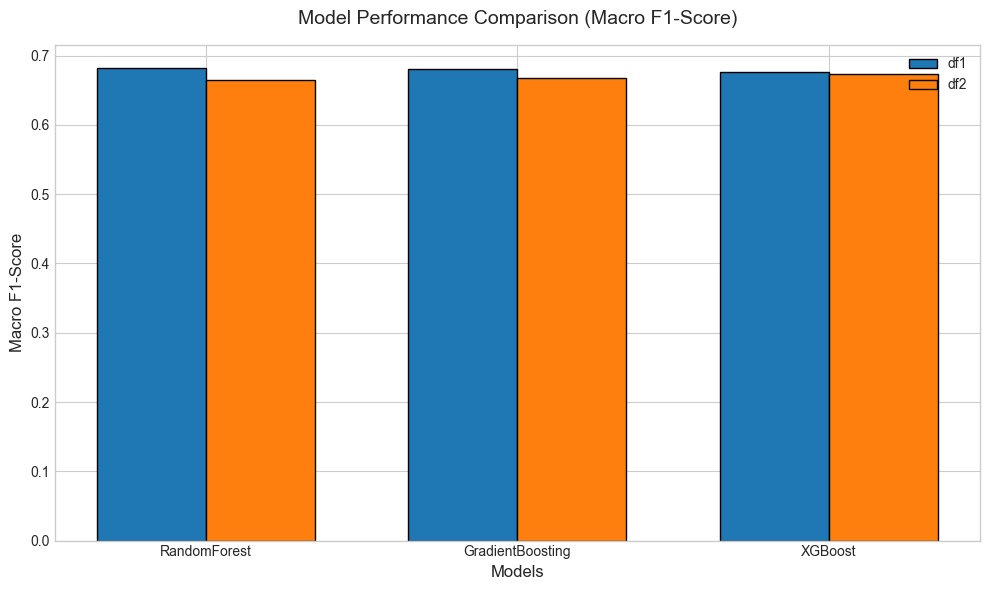

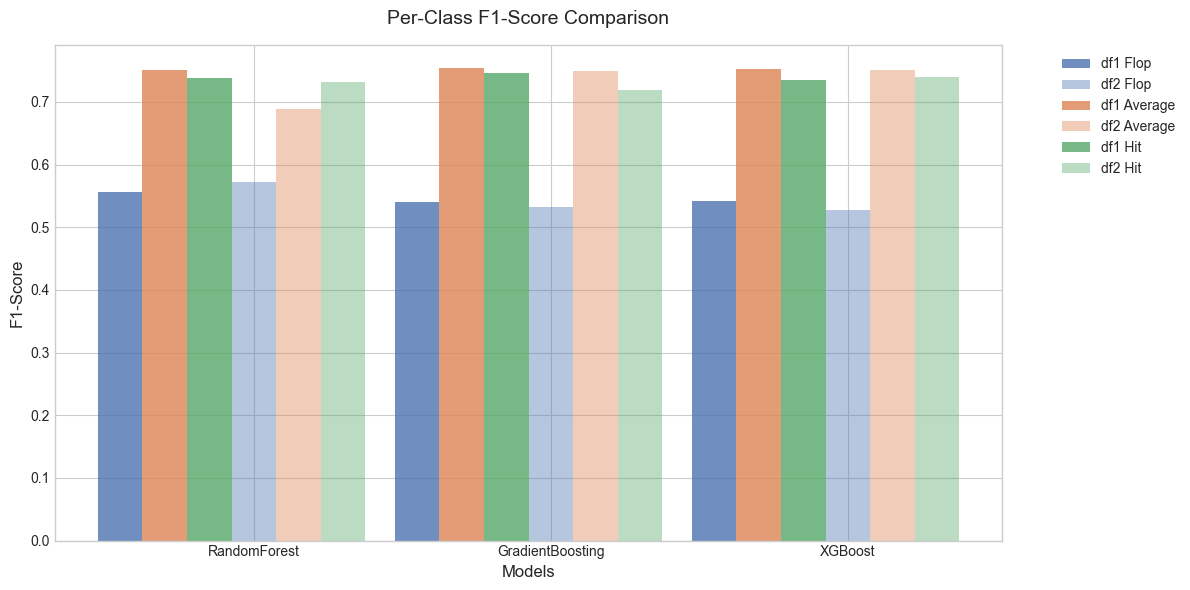

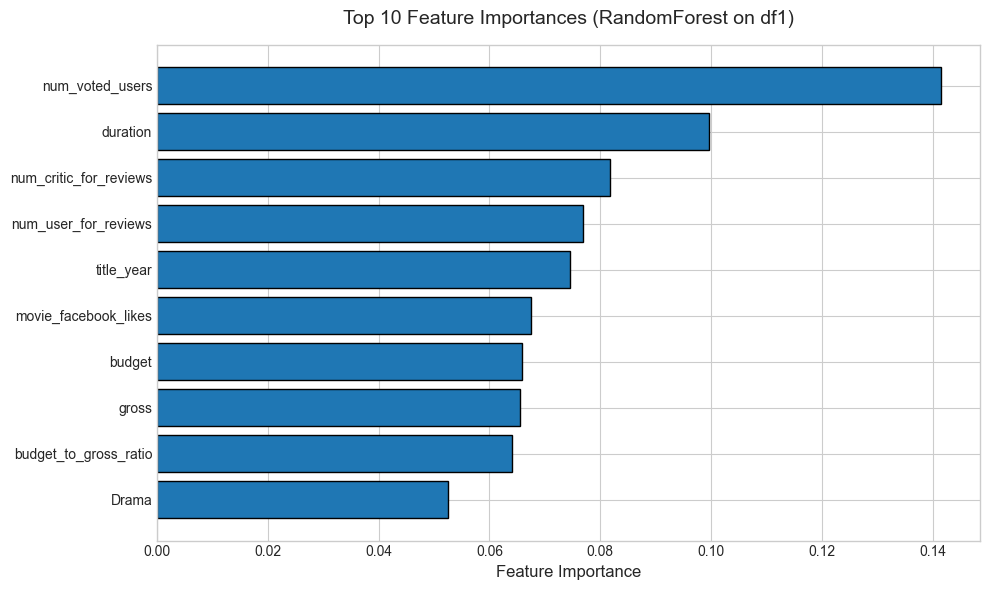


=== Summary ===
Best Model for df1: RandomForest (Macro F1: 0.681)
Best Model for df2: XGBoost (Macro F1: 0.673)
Overall Best: RandomForest on df1 (Macro F1: 0.681)
This model will be used for predicting movie success in production!


In [18]:
# Let’s train our models on both df1 and df2, compare their performance, and visualize the results! ⚡
# I’ll focus on macro F1-score, per-class F1-scores, and accuracy to pick the best model for the studio.
# We’ll also store the preprocessed DataFrames for tagline and strategy generation.

# Step 1: Run the pipeline on df1 and df2
print("=== Training and Evaluating on df1 ===")
results_df1, best_rf_df1, feature_names_df1, preprocessed_df1, preprocessing_tools_df1 = preprocess_train_and_evaluate(df1)

print("\n=== Training and Evaluating on df2 ===")
results_df2, best_rf_df2, feature_names_df2, preprocessed_df2, preprocessing_tools_df2 = preprocess_train_and_evaluate(df2)

# Step 2: Compare model performance
model_names = ['RandomForest', 'GradientBoosting', 'XGBoost']
# Extract macro F1-scores and accuracy for overall comparison
f1_scores_df1 = [results_df1[model]['macro_f1'] for model in model_names]
f1_scores_df2 = [results_df2[model]['macro_f1'] for model in model_names]
accuracy_df1 = [results_df1[model]['classification_report']['accuracy'] for model in model_names]
accuracy_df2 = [results_df2[model]['classification_report']['accuracy'] for model in model_names]
# Extract per-class F1-scores for detailed comparison
classes = ['Flop', 'Average', 'Hit']
f1_per_class_df1 = {cls: [results_df1[model]['classification_report'][cls]['f1-score'] for model in model_names] for cls in classes}
f1_per_class_df2 = {cls: [results_df2[model]['classification_report'][cls]['f1-score'] for model in model_names] for cls in classes}

# Display overall comparison (macro F1-score and accuracy)
print("\n=== Model Comparison (Macro F1-Score and Accuracy) ===")
print("Model\t\t\tdf1 Macro F1\tdf1 Accuracy\tdf2 Macro F1\tdf2 Accuracy")
print("-" * 70)
for model, f1_df1, acc_df1, f1_df2, acc_df2 in zip(model_names, f1_scores_df1, accuracy_df1, f1_scores_df2, accuracy_df2):
    print(f"{model:<15}\t{f1_df1:.3f}\t\t{acc_df1:.3f}\t\t{f1_df2:.3f}\t\t{acc_df2:.3f}")

# Display per-class F1-scores for deeper insight
print("\n=== Per-Class F1-Scores ===")
for cls in classes:
    print(f"\nClass: {cls}")
    print(f"{'Model':<15}{'df1 F1':<10}{'df2 F1':<10}")
    print("-" * 35)
    for model, f1_df1, f1_df2 in zip(model_names, f1_per_class_df1[cls], f1_per_class_df2[cls]):
        print(f"{model:<15}{f1_df1:.3f}\t{f1_df2:.3f}")

# Step 3: Visualize macro F1-score comparison
plt.figure(figsize=(10, 6))
x = np.arange(len(model_names))
width = 0.35

plt.bar(x - width/2, f1_scores_df1, width, label='df1', color='#1f77b4', edgecolor='black')
plt.bar(x + width/2, f1_scores_df2, width, label='df2', color='#ff7f0e', edgecolor='black')

plt.xlabel('Models', fontsize=12)
plt.ylabel('Macro F1-Score', fontsize=12)
plt.title('Model Performance Comparison (Macro F1-Score)', fontsize=14, pad=15)
plt.xticks(x, model_names, fontsize=10)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig('macro_f1_comparison.png')  # Save for presentation
plt.show()

# Step 4: Visualize per-class F1-score comparison
plt.figure(figsize=(12, 6))
width = 0.15
x = np.arange(len(model_names))
for i, cls in enumerate(classes):
    plt.bar(x + (i - 1) * width, f1_per_class_df1[cls], width, label=f'df1 {cls}', color=f'C{i}', alpha=0.8)
    plt.bar(x + (i - 1) * width + len(classes) * width, f1_per_class_df2[cls], width, label=f'df2 {cls}', color=f'C{i}', alpha=0.4)

plt.xlabel('Models', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.title('Per-Class F1-Score Comparison', fontsize=14, pad=15)
plt.xticks(x + width * (len(classes) - 1), model_names, fontsize=10)
plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('per_class_f1_comparison.png')  # Save for presentation
plt.show()

# Step 5: Feature importance for the best RandomForest model (from df1)
plt.figure(figsize=(10, 6))
importances = best_rf_df1.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10 features
plt.barh(range(len(indices)), importances[indices], align='center', color='#1f77b4', edgecolor='black')
plt.yticks(range(len(indices)), [feature_names_df1[i] for i in indices], fontsize=10)
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Top 10 Feature Importances (RandomForest on df1)', fontsize=14, pad=15)
plt.tight_layout()
plt.savefig('feature_importance_df1.png')  # Save for presentation
plt.show()

# Step 6: Summarize the best model and DataFrame
# Find the best model based on macro F1-score
best_f1_df1 = max(f1_scores_df1)
best_f1_df2 = max(f1_scores_df2)
best_model_df1 = model_names[f1_scores_df1.index(best_f1_df1)]
best_model_df2 = model_names[f1_scores_df2.index(best_f1_df2)]

print("\n=== Summary ===")
print(f"Best Model for df1: {best_model_df1} (Macro F1: {best_f1_df1:.3f})")
print(f"Best Model for df2: {best_model_df2} (Macro F1: {best_f1_df2:.3f})")
if best_f1_df1 > best_f1_df2:
    print(f"Overall Best: {best_model_df1} on df1 (Macro F1: {best_f1_df1:.3f})")
    best_overall_model = results_df1[best_model_df1]['best_estimator']
    best_overall_feature_names = feature_names_df1
    best_overall_preprocessed_df = preprocessed_df1
    best_overall_preprocessing_tools = preprocessing_tools_df1
else:
    print(f"Overall Best: {best_model_df2} on df2 (Macro F1: {best_f1_df2:.3f})")
    best_overall_model = results_df2[best_model_df2]['best_estimator']
    best_overall_feature_names = feature_names_df2
    best_overall_preprocessed_df = preprocessed_df2
    best_overall_preprocessing_tools = preprocessing_tools_df2

print("This model will be used for predicting movie success in production!")

# Marketing Tagline and Strategy Generation <a id="tagline-generation"></a> 

With our best model (RandomForest on df1, Macro F1: 0.681) ready, let’s predict the success of 5 movies and use a pretrained LLM (Deepseek-v3 via [openrouter.ai](https://openrouter.ai)) to generate marketing taglines and strategies! We’ll extract genres and plot keywords from the preprocessed DataFrame, predict the movies’ success (Flop, Average, Hit), and prompt the LLM to create 5 creative taglines and a tailored marketing strategy for each movie. For Hits, we’ll focus on maintaining hype; for Average movies, we’ll aim to boost success; and for Flops, we’ll strategize to recover investment. Let’s make these movies shine! 🎬

In [ ]:
# Let’s predict movie success for 5 movies and use DeepSeek’s API (via OpenRouter) to generate marketing taglines and strategies! 🎥

# Step 1: Select 5 movies from the preprocessed DataFrame
# Since the best model is RandomForest on df1, we’ll use preprocessed_df1
# We’ll randomly sample 5 movies and extract their features, genres, and plot_keywords
test_movies = best_overall_preprocessed_df.sample(n=5, random_state=42)

# Step 2: Prepare features for prediction
# The preprocessed DataFrame already has encoded features, so we just need to drop the columns not used in modeling
feature_cols = [col for col in best_overall_feature_names if col in test_movies.columns]
X_test = test_movies[feature_cols]

# Step 3: Predict movie success using the best model (RandomForest on df1)
y_pred = best_overall_model.predict(X_test)

# Step 4: Set up DeepSeek API via OpenRouter
from openai import OpenAI

# Initialize the OpenAI client for OpenRouter with your API key
client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key="[Replace with your API key here]"
)

# Step 5: Generate marketing taglines and strategies for each movie using DeepSeek
print("\n=== Marketing Taglines and Strategies for Test Movies ===")
for i in range(len(test_movies)):
    movie = test_movies.iloc[i]
    prediction = y_pred[i]
    genres = movie['genres']
    plot_keywords = movie['plot_keywords']
    
    # Generate taglines
    tagline_prompt = (
        f"Generate 5 short, catchy marketing taglines for a movie with the following details:\n"
        f"- Predicted Success: {prediction}\n"
        f"- Genres: {genres}\n"
        f"- Plot Keywords: {plot_keywords}\n"
        f"Provide the taglines as a numbered list:\n"
        f"1. First tagline\n"
        f"2. Second tagline\n"
        f"3. Third tagline\n"
        f"4. Fourth tagline\n"
        f"5. Fifth tagline\n"
    )
    tagline_response = client.chat.completions.create(
        model="deepseek/deepseek-chat:free",  # Use DeepSeek-V3 via OpenRouter
        messages=[
            {"role": "system", "content": "You are a creative marketing assistant specializing in movie promotions."},
            {"role": "user", "content": tagline_prompt}
        ],
        temperature=0.7,
        top_p=0.9,
        max_tokens=500
    )
    tagline_text = tagline_response.choices[0].message.content
    
    # Extract taglines
    taglines = []
    lines = tagline_text.split('\n')
    for line in lines:
        if line.strip().startswith(tuple(f"{i}." for i in range(1, 6))):
            tagline = line.split('.', 1)[1].strip()
            if tagline and tagline != "First tagline" and tagline != "Second tagline" and tagline != "Third tagline" and tagline != "Fourth tagline" and tagline != "Fifth tagline":
                taglines.append(tagline)
    if not taglines:
        taglines_text = "Could not generate meaningful taglines."
    else:
        taglines_text = "\n".join(f"{i+1}. {tagline}" for i, tagline in enumerate(taglines[:5]))

    # Generate marketing strategy with updated prompt
    strategy_prompt = (
        f"Generate a marketing strategy for a movie with the following details:\n"
        f"- Predicted Success: {prediction}\n"
        f"- Genres: {genres}\n"
        f"- Plot Keywords: {plot_keywords}\n"
        f"Based on the predicted success:\n"
        f"- If a Hit: Focus on maintaining hype and maximizing reach.\n"
        f"- If Average: Suggest ways to boost its success and appeal.\n"
        f"- If a Flop: Propose a plan to recover investment and minimize losses.\n"
        f"Start your response with 'Marketing Strategy:' and provide a concise strategy in 2-3 sentences.\n"
    )
    strategy_response = client.chat.completions.create(
        model="deepseek/deepseek-chat:free",  # Use DeepSeek-V3 via OpenRouter
        messages=[
            {"role": "system", "content": "You are a creative marketing assistant specializing in movie promotions."},
            {"role": "user", "content": strategy_prompt}
        ],
        temperature=0.7,
        top_p=0.9,
        max_tokens=500
    )
    strategy_text = strategy_response.choices[0].message.content
    
    # Extract strategy with relaxed parsing
    strategy_start = strategy_text.find("Marketing Strategy:")
    if strategy_start != -1:
        # If the marker is found, extract the text after it
        strategy_text = strategy_text[strategy_start+len("Marketing Strategy:"):].strip()
    else:
        # If the marker isn't found, assume the entire response is the strategy
        strategy_text = strategy_text.strip()
    
    # Take the first 2-3 sentences
    strategy_sentences = strategy_text.split('.')
    strategy_text = '. '.join([s.strip() for s in strategy_sentences[:3] if s.strip()]) + ('.' if strategy_text.strip() else '')
    if not strategy_text:
        strategy_text = "Could not generate a meaningful strategy."

    # Print the results
    print(f"\nMovie {i+1}:")
    print(f"  Genres: {genres}")
    print(f"  Plot Keywords: {plot_keywords}")
    print(f"  Predicted Success: {prediction}")
    print(f"  Taglines:")
    print(taglines_text)
    print(f"  Marketing Strategy:")
    print(strategy_text if strategy_text else "No strategy generated.")


=== Marketing Taglines and Strategies for Test Movies ===

Movie 1:
  Genres: Action|Adventure|Romance|Sci-Fi
  Plot Keywords: 1770s|british india|great barrier reef|india|ring
  Predicted Success: Flop
  Taglines:
1. "A Timeless Adventure That Misses the Mark – Dive In Anyway!"
2. "From the Sands of British India to the Depths of the Reef – A Journey Like No Other!"
3. "Love, Action, and a Mysterious Ring – But Will It Shine?"
4. "1770s India Meets Sci-Fi Spectacle – A Bold Experiment!"
5. "A Cinematic Voyage That’s More Reef Than Riches!"
  Marketing Strategy:
Given the predicted flop, focus on niche marketing by targeting history enthusiasts, adventure seekers, and fans of period dramas through specialized platforms like history blogs, travel forums, and romance book clubs. Leverage the unique setting of 1770s British India and the Great Barrier Reef to create immersive social media campaigns and limited-time streaming partnerships to recover investment and minimize losses.

Movie 